In [1]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dplyr)
  library(dataorganizer)
  library(devtools)
  library(cellAdmix)
  library(ggplot2)
  library(readr)
  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
# load data
data <- prepare_gut_tx_and_meta()
cell_annot <- data[[1]]
df <- data[[2]]
so_rna <- prepare_gut_scrna()

In [3]:
base_dir <- CachePath('gut_scaled_dat6/')

k_joint <- c(5,15,20,30)
k_ct <- c(5)

In [4]:
# load NMF and CRF results
res <- load_nmf_crf_multi(k_joint, k_ct, base_dir)
all_nmf <- res[[1]]
crf_all <- res[[2]]

In [5]:
# load saved enrichment results
enr_res_all <- file.path(base_dir, 'enrich_results.rds') %>% readRDS()

In [6]:
# load and extract bridge results
all_ctypes <- unique(cell_annot$celltype)
bridge_res_all <- extract_bridge_multi(all_nmf,all_ctypes=all_ctypes,
                                       dir=base_dir,bridge_pthresh=.3,
                                       bridge_adj_pvals=FALSE)

In [7]:
# load and extract bridge results
memb_res_all <- extract_memb_multi(all_nmf,all_ctypes=all_ctypes,
                                   dir=base_dir,memb_pthresh=.2,
                                   memb_adj_pvals=FALSE)

In [8]:
fp_checks <- check_fp_multi(df,cell_annot,crf_all,enr_res_all=enr_res_all,
                            bridge_res_all=bridge_res_all,memb_res_all=memb_res_all,
                            do_clean=TRUE,knn_k=100,median_thresh=.2)
annot_res_all <- fp_checks[[1]]
orig_nms_all <- fp_checks[[2]]

In [10]:
# compute cell adj mat for scores calculation
df$cell_type <- df$celltype
sc_ctypes <- unique(so_rna$cell_type)
df_ct_match <- df[df$cell_type %in% sc_ctypes,]
cell_adj_df <- estimate_cell_adjacency(df_ct_match, random.shift=1e-2, n.cores=10)

In [11]:
dbl_score_params <- list(
  signal_thres=0.25,
  exclude_genes=exclude_genes <- list(
    all=c('Ada', 'Tnfrsf21', 'Marcksl1'),
    Goblet=c('Cps1', 'Maoa', 'Clca3b', 'H2-Eb1'),
    Paneth=c('Hmgb2', 'H2-Eb1')
  ),
  p.c=.25,
  min.expr.frac=0.05,
  exclude.cell.types=c('Other'),
  max.prob.high=0.01
)


In [12]:
# compute admixture probability scores
scores_final_df <- suppressWarnings(get_scores_multi(annot_res_all,orig_nms_all,dbl_score_params,
                                    df,so_rna,crf_all,cell_adj_df,n.cores=18))

Normalizing layer: counts



In [13]:
# saving all scores
saveRDS(scores_final_df, file.path(base_dir,'scores_final_df.rds'))

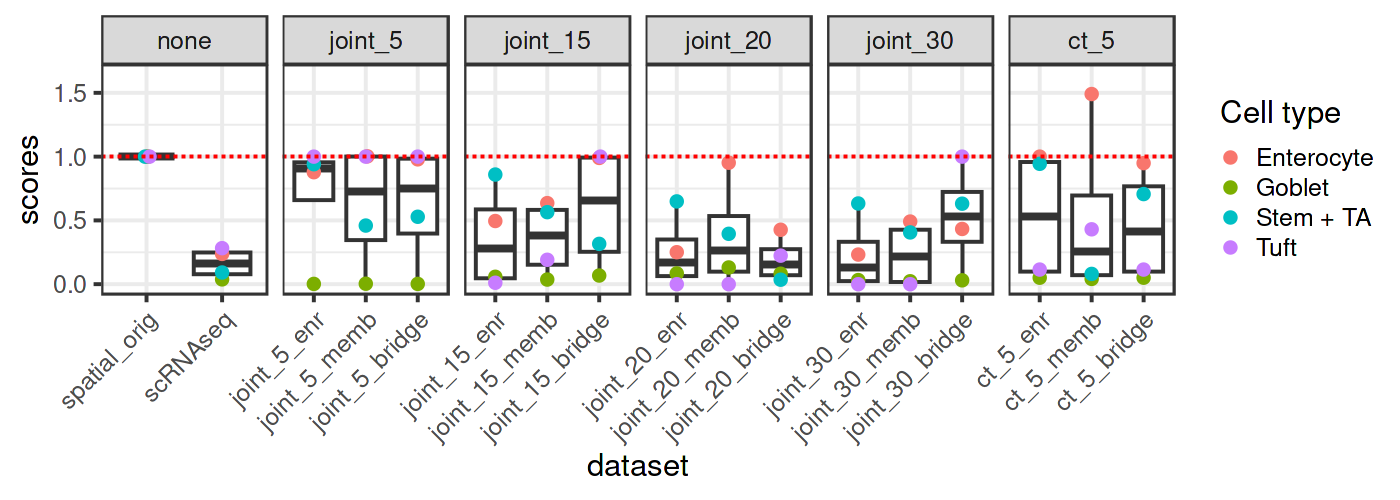

In [14]:
options(repr.plot.width = 7, repr.plot.height = 2.5, repr.plot.res = 200)

p <- plot_ct_av_norm_scores(scores_final_df,trim_level=.1,min_mean_thresh = 1e-3)
p

In [15]:
res_nm <- 'joint_20_bridge'
res_nm_splt <- strsplit(res_nm,split='_')[[1]]
f_rm <- annot_res_all[[res_nm]]
crf_res <- crf_all[[paste0(res_nm_splt[[1]],'_',res_nm_splt[[2]])]]
scores_orig <- scores_final_df[scores_final_df$dataset=='spatial_orig',]
scores_cln <- scores_final_df[scores_final_df$dataset==res_nm,]

plts <- plot_cell_score_ratios(
  scores_orig,scores_cln,f_rm,df,crf_res,
  upper.lim=1.5, min.mean.thresh=1e-3
)

Picking joint bandwidth of 0.0903



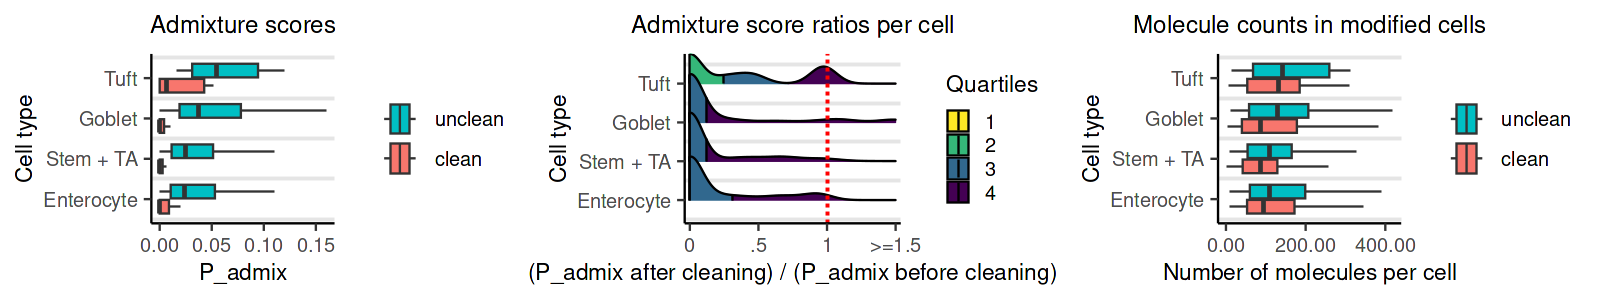

In [16]:
options(repr.plot.width = 8, repr.plot.height = 1.5, repr.plot.res = 200)
fig <- plot_grid(plotlist=plts[c(1,2,4)],nrow=1,align='h')
fig

In [18]:
pdf(OutputPath("gut_cell_score_ratios.pdf"), useDingbats=FALSE, width=8, height=1.5)
fig
dev.off()

png 
  2

In [19]:
saveRDS(plts[c(1,2,4)], CachePath("gut_cell_score_ratios2.rds"))

In [21]:
# saving an original counts version of the data
so_spatial_orig <- get_counts_meta_seurat(df,normalize=TRUE)
write_rds(so_spatial_orig, file.path(base_dir, "so_spatial_orig.rds"))

Normalizing layer: counts



In [23]:
# saving a cleaned counts version of the data
k <- 20
f_rm <- annot_res_all[[paste0('joint_',k,'_bridge')]]

# clean the df
df$factor <- crf_res[,1]
df_cln <- df[!(paste(df$factor, df$celltype, sep = "_") %in% f_rm), ]

# make and save a counts version of df_cln
so_spatial_cln <- get_counts_meta_seurat(df_cln,normalize=TRUE)
write_rds(so_spatial_cln, paste0(base_dir, "so_spatial_cln_", k, "_full.rds"))

Normalizing layer: counts

